In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')


In [2]:
aep = pd.read_csv('AEP_hourly.csv',index_col=[0], parse_dates=[0])
aep.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


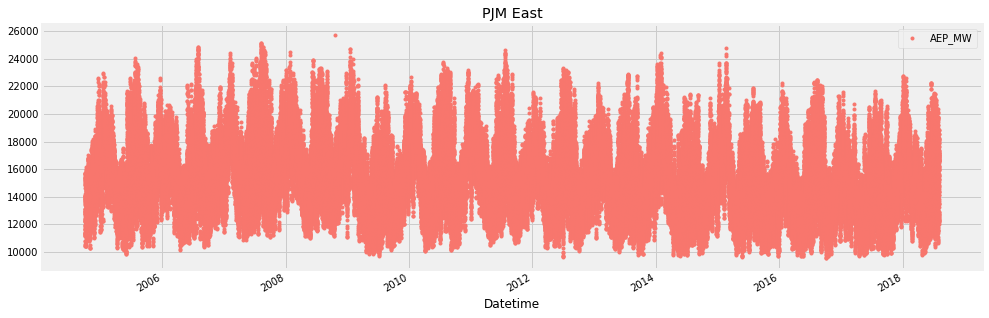

In [3]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = aep.plot(style='.', figsize=(15,5), color=color_pal[0], title='AEP East')

In [4]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(aep, label='AEP_MW')

features_and_target = pd.concat([X, y], axis=1)

In [5]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,AEP_MW
Datetime,,,,,,,,,
2004-12-31 01:00:00,1,4,4,12,2004,366,31,53,13478.0
2004-12-31 02:00:00,2,4,4,12,2004,366,31,53,12865.0
2004-12-31 03:00:00,3,4,4,12,2004,366,31,53,12577.0
2004-12-31 04:00:00,4,4,4,12,2004,366,31,53,12517.0
2004-12-31 05:00:00,5,4,4,12,2004,366,31,53,12670.0


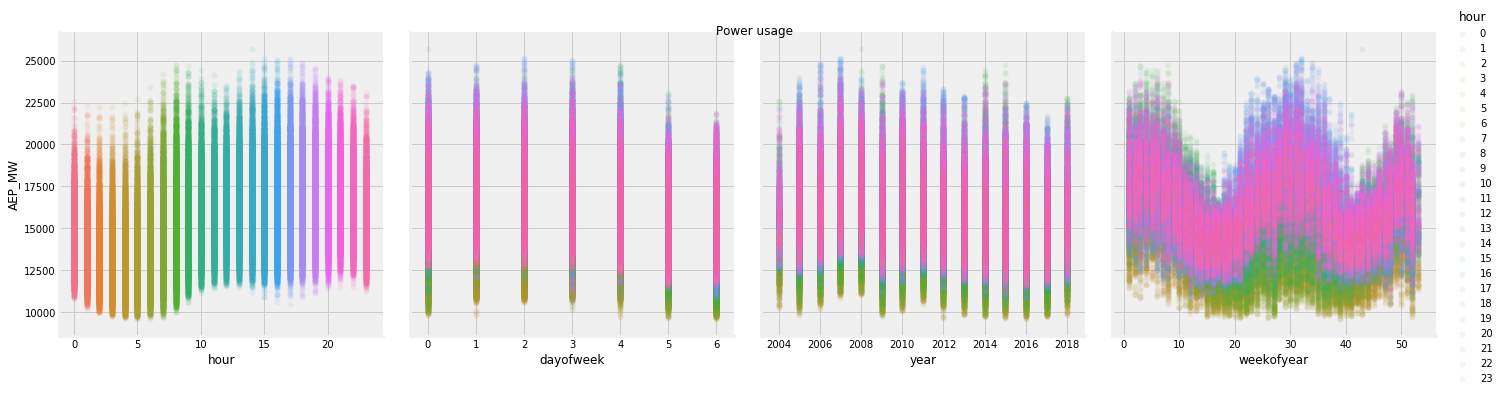

In [6]:
sns.pairplot(features_and_target.dropna(),
            hue= 'hour',
            x_vars=['hour','dayofweek','year','weekofyear'],
             y_vars='AEP_MW',
             height=5,
             plot_kws={'alpha':0.1, 'linewidth':0}
            )
plt.suptitle('Power usage')

plt.show()

## Train/Test SPlit

In [7]:
split_date = '01-Jan-2015'
aep_train = aep.loc[aep.index <= split_date].copy()
aep_test = aep.loc[aep.index > split_date].copy()


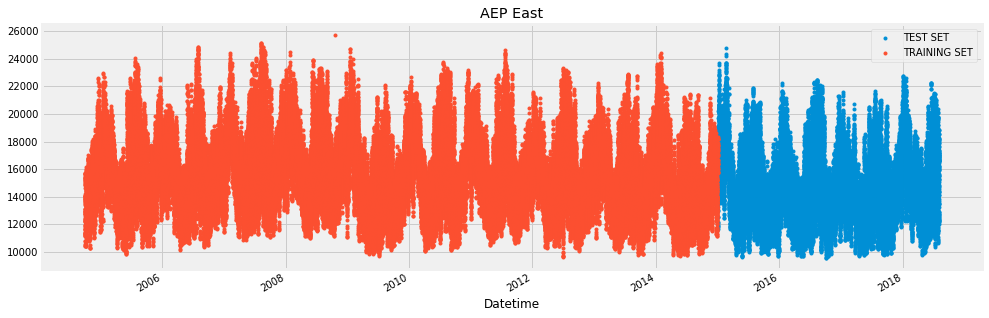

In [8]:
_ = aep_test \
    .rename(columns={'AEP_MW': 'TEST SET'}) \
    .join(aep_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='AEP East', style='.')


In [9]:
aep_train.reset_index().rename(columns={'Datetime' : 'ds', 'AEP_MW': 'y'}).head()

,ds,y
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [10]:
model = Prophet()
model.fit(aep_train.reset_index().rename(columns={'Datetime':'ds', 'AEP_MW':'y'}))

/anaconda3/envs/PythonData/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [11]:
aep_test_fcst = model.predict(df=aep_test.reset_index().rename(columns={'Datetime':'ds'}))

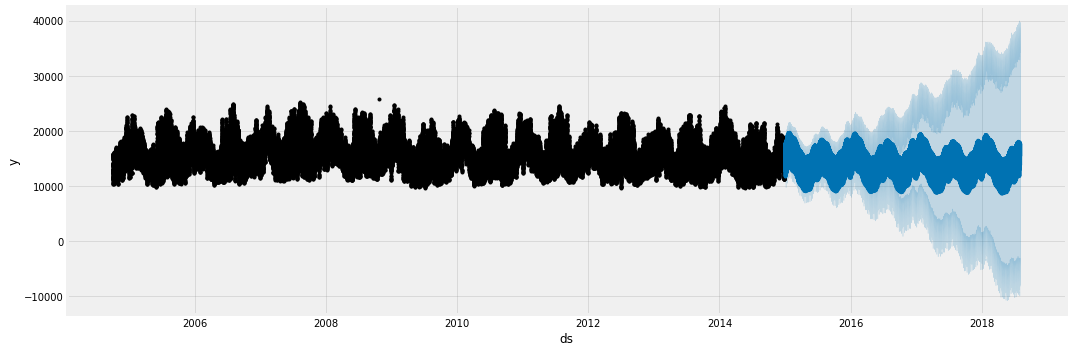

In [12]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(aep_test_fcst, ax=ax)

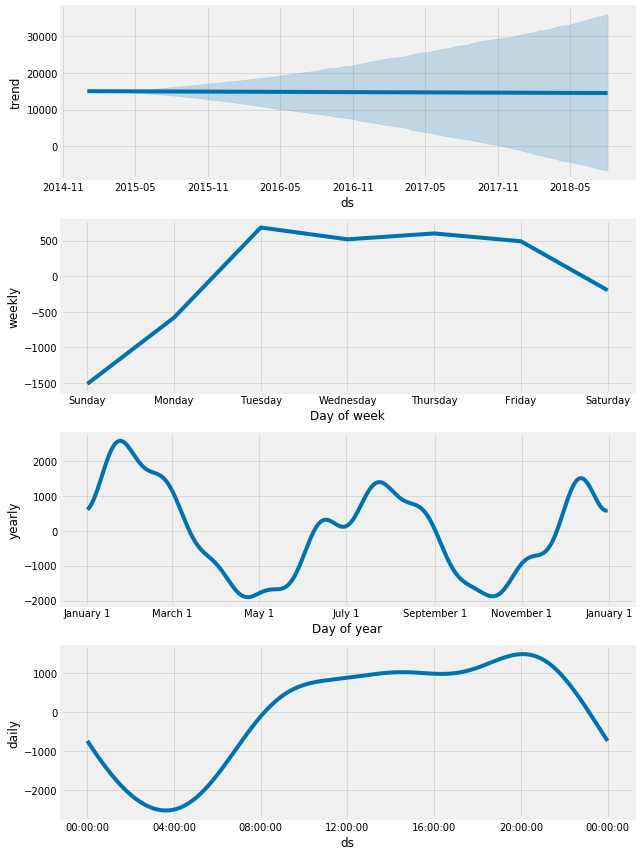

In [13]:
fig = model.plot_components(aep_test_fcst)

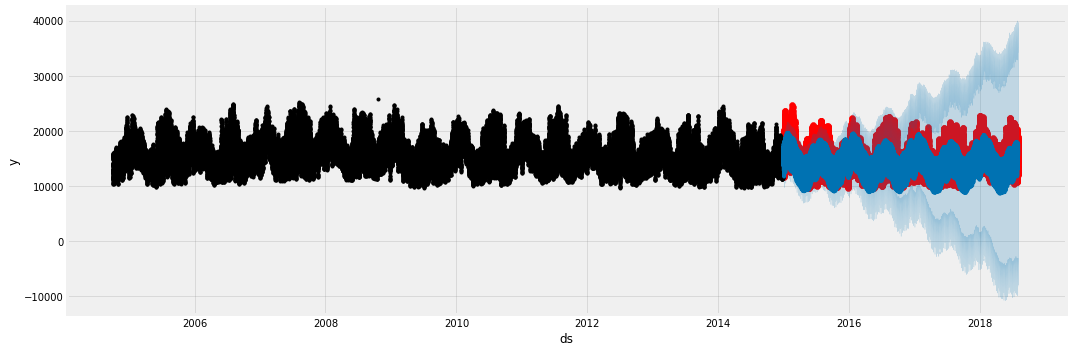

In [14]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(aep_test.index, aep_test['AEP_MW'], color='r')
fig = model.plot(aep_test_fcst, ax=ax)

## Look at first month of predicitions 

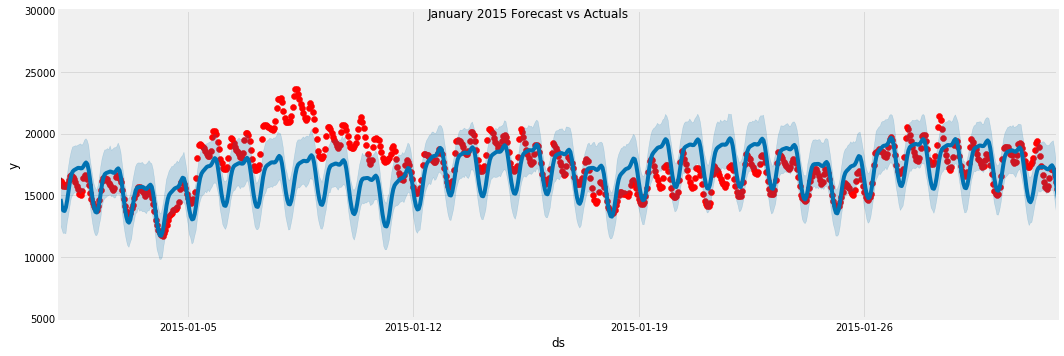

In [15]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(aep_test.index, aep_test['AEP_MW'], color='r')
fig = model.plot(aep_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(5000, 30000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')
plt.show()

## Single Week of Predicitions 

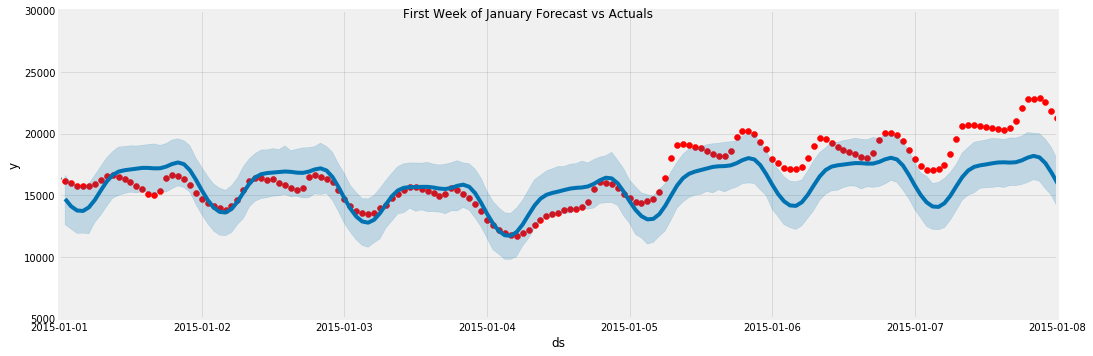

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(aep_test.index, aep_test['AEP_MW'], color='r')
fig = model.plot(aep_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(5000, 30000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

## Error Metrics
Our RMSE error is 43761675
Our MAE error is 5181.78
Our MAPE error is 16.5%

In [17]:
mean_squared_error(y_true=aep_test['AEP_MW'],
                   y_pred=aep_test_fcst['yhat'])

6779829.59845304

In [18]:
mean_absolute_error(y_true=aep_test['AEP_MW'],
                   y_pred=aep_test_fcst['yhat'])

2080.213366614962

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=aep_test['AEP_MW'],
                   y_pred=aep_test_fcst['yhat'])

14.163588794545234

## Adding Holidays 


In [20]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=aep_train.index.min(), end=aep_train.index.max())
test_holidays = cal.holidays(start=aep_test.index.min(), end=aep_test.index.max())

In [21]:
# Create a dataframe with holiday, ds columns
aep['date'] = aep.index.date
aep['is_holiday'] = aep.date.isin([d.date() for d in cal.holidays()])
holiday_df = aep.loc[aep['is_holiday']].reset_index().rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['AEP_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2004-12-31 01:00:00,USFederalHoliday
1,2004-12-31 02:00:00,USFederalHoliday
2,2004-12-31 03:00:00,USFederalHoliday
3,2004-12-31 04:00:00,USFederalHoliday
4,2004-12-31 05:00:00,USFederalHoliday


In [22]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(aep_train.reset_index().rename(columns={'Datetime':'ds', 'AEP_MW':'y'}))

/anaconda3/envs/PythonData/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


## Plot Holiday Effect

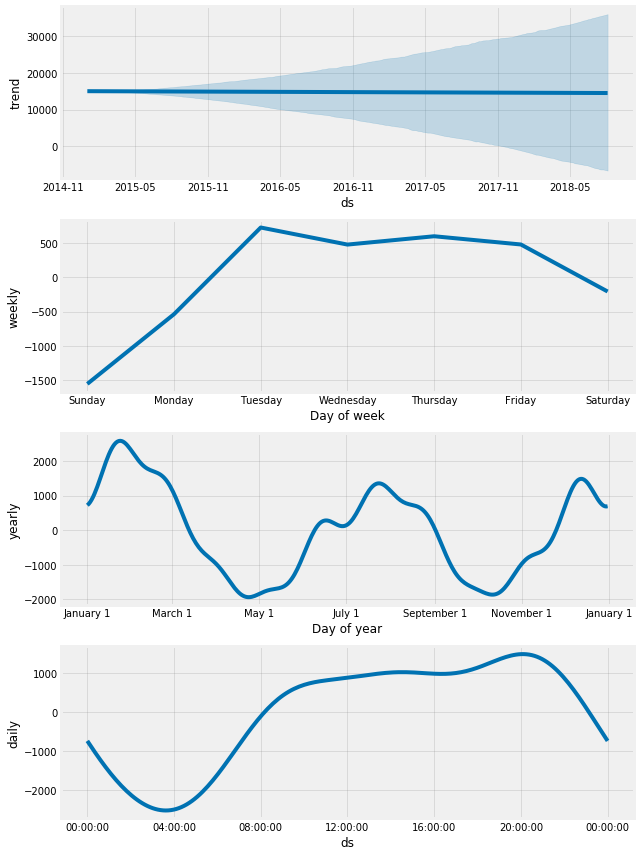

In [23]:
fig2 = model_with_holidays.plot_components(aep_test_fcst)

## Predict With Holidays 

In [24]:
aep_test_fcst_with_hols = model_with_holidays.predict(df=aep_test.reset_index().rename(columns={'Datetime':'ds'}))

In [25]:
aep_test_fcst_with_hols.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,USFederalHoliday,USFederalHoliday_lower,USFederalHoliday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,15048.523287,11682.985638,15730.799370,15048.523287,15048.523287,-1028.296885,-1028.296885,-1028.296885,-1240.068370,...,606.054067,606.054067,606.054067,708.753286,708.753286,708.753286,0.0,0.0,0.0,13808.454917
1,2015-01-01 02:00:00,15048.507265,11391.716501,15063.783088,15048.507265,15048.507265,-1028.296885,-1028.296885,-1028.296885,-1834.225979,...,607.625801,607.625801,607.625801,709.831127,709.831127,709.831127,0.0,0.0,0.0,13214.281286
2,2015-01-01 03:00:00,15048.491243,11100.073448,14712.359725,15048.491243,15048.491243,-1028.296885,-1028.296885,-1028.296885,-2175.034435,...,608.321476,608.321476,608.321476,710.934254,710.934254,710.934254,0.0,0.0,0.0,12873.456808
3,2015-01-01 04:00:00,15048.475221,10928.173252,14735.269503,15048.475221,15048.475221,-1028.296885,-1028.296885,-1028.296885,-2213.032250,...,608.153406,608.153406,608.153406,712.062666,712.062666,712.062666,0.0,0.0,0.0,12835.442971
4,2015-01-01 05:00:00,15048.459199,11252.728999,14969.749268,15048.459199,15048.459199,-1028.296885,-1028.296885,-1028.296885,-1916.083237,...,607.144376,607.144376,607.144376,713.216358,713.216358,713.216358,0.0,0.0,0.0,13132.375963
